In [1]:
import polars as pl
import polars_ds as pds

In [2]:
df = pl.read_parquet("../examples/dependency.parquet")
df.head()

ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
str,str,str,str,str,str,str,str,i64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,i64,i64
"""APPC90493171225""","""Female""","""23/07/79""","""15/07/16""","""C10001""","""A""","""COM0044082""","""A""",4,2000.0,"""B001""","""P""","""N""","""S122""","""G""",0.0,null,null,null,null,0,0
"""APPD40611263344""","""Male""","""07/12/86""","""04/07/16""","""C10003""","""A""","""COM0000002""","""C""",1,3500.0,"""B002""","""P""","""Y""","""S122""","""G""",0.0,20000,2,13.25,953,10,0
"""APPE70289249423""","""Male""","""10/12/82""","""19/07/16""","""C10125""","""C""","""COM0005267""","""C""",4,2250.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,45000,4,null,null,0,0
"""APPF80273865537""","""Male""","""30/01/89""","""09/07/16""","""C10477""","""C""","""COM0004143""","""A""",4,3500.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,92000,5,null,null,7,0
"""APPG60994436641""","""Male""","""19/04/85""","""20/07/16""","""C10002""","""A""","""COM0001781""","""A""",4,10000.0,"""B001""","""P""","""Y""","""S134""","""B""",2500.0,50000,2,null,null,10,0


In [5]:
from polars_ds.pipeline import Pipeline
import polars.selectors as cs

# df.select(pl.col("Existing_EMI"))

pipe = (
    Pipeline(df)
    .lowercase()
    .impute(["existing_emi"], method = "median")
    .select(cs.numeric())
    .append_expr([
        pl.col("existing_emi").log1p().alias("existing_emi_log1p"),
        pl.col("loan_amount").log1p().alias("loan_amount_log1p"),
        pl.col("loan_amount").sqrt().alias("loan_amount_sqrt"),
    ])
    .scale(
        cs.numeric().exclude(["var1", "existing_emi_log1p"]), method = "min_max"
    ).remove(
        ["approved"]
    )
)

pipe.fit()
pipe.transform()

employer_category2,monthly_income,existing_emi,loan_amount,loan_period,interest_rate,emi,var1,existing_emi_log1p,loan_amount_log1p,loan_amount_sqrt
f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64
1.0,0.000052,0.0,null,null,null,null,0,0.0,null,null
0.0,0.000091,0.0,0.050847,0.2,0.05038,0.062137,10,0.0,0.338567,0.148237
1.0,0.000059,0.0,0.135593,0.6,null,null,0,0.0,0.536631,0.296473
1.0,0.000091,0.0,0.294915,0.8,null,null,7,0.0,0.711299,0.487628
1.0,0.000261,0.004583,0.152542,0.2,null,null,10,7.824446,0.562365,0.320529
…,…,…,…,…,…,…,…,…,…,…
0.0,0.000128,0.0,null,null,null,null,10,0.0,null,null
1.0,0.000187,0.002658,null,null,null,null,7,7.280008,null,null
1.0,0.000042,0.0,0.064407,0.6,0.940024,0.061393,2,0.0,0.383097,0.176534


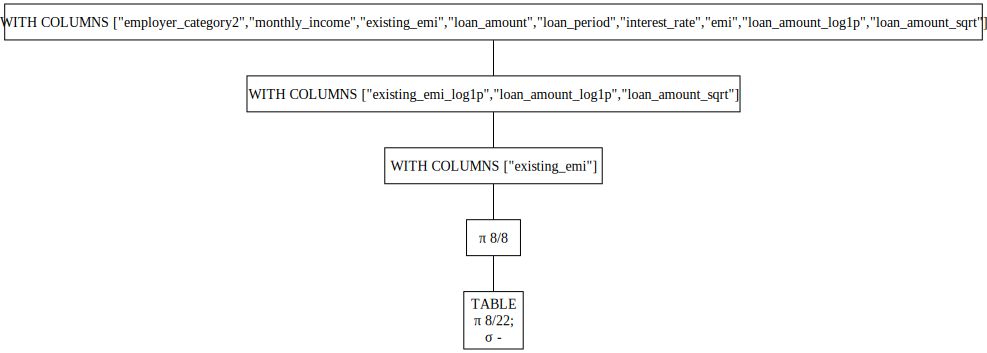

In [6]:
pipe.show_graph()

In [ ]:
df = pds.random_data(size=100_000, n_cols = 0).select(
    pds.random_int(0, 200).alias("x"),
    pds.random_int(0, 200).alias("y"),
    pl.Series([1] * 50_000 + [2] * 50_000).alias("test")
)
df.head()

In [ ]:
df.select(
    pds.query_lstsq_report("x", target="y", add_bias=True).alias("report")
)["report"]

In [ ]:
df.select(
    pl.col("x").qcut(10, left_closed=False, allow_duplicates=True, include_breaks=True)
        .struct.field("brk")
        .value_counts()
        .sort()
).unnest("brk")

In [ ]:
df.select(
    pl.corr("x", "y")
)

In [ ]:

df.select(
    pds.kendall_tau("x", "y")
)

In [ ]:
from scipy.stats import kendalltau

x = df["x"].to_numpy()
y = df["y"].to_numpy()

In [ ]:
%%timeit
kendalltau(x,y, nan_policy="omit")

In [ ]:
df.sort(pl.col("x").rank(method="random")).select(
    "x",
    "y",
    pl.col("y").rank(method="max").cast(pl.Float64).alias("r"),
    (-pl.col("y")).rank(method="max").cast(pl.Float64).alias("l"),
).with_columns(
    pl.col("r").diff().abs().alias("r_abs_diff"),
    (pl.col("l") * (pl.len() - pl.col("l"))).alias("l(n-l)"),
).select(
    1 - (pl.len() / 2) * (pl.col("r_abs_diff").sum() / pl.col("l(n-l)").sum())
)